# Modelling tides

## Getting started
As a first step, we need to tell `eo-tides` the location of our tide model directory that contains our downloaded tide model data ([refer to the detailed setup instructions here](../setup.md) if you haven't set this up).

We will pass this path to `eo-tides` functions using the `directory` parameter.

<div class="alert alert-info">
    
**Note:** Update the `directory` path below to point to the location of your own tide model directory.

</div>

<!-- For local installation:
pip install -e ../../. -->

In [1]:
directory = "../../tests/data/tide_models_tests"

## Using "model_tides"

To model tide heights for a specific location and set of timesteps, we can use the `eo_tides.model.model_tides` function. 
For example, we can model hourly tides across a one month period (January 2028):

In [2]:
from eo_tides.model import model_tides
import pandas as pd

tide_df = model_tides(
    x=122.2186,
    y=-18.0008,
    time=pd.date_range(start="2018-01-01", end="2018-01-20", freq="1h"),
    directory=directory,
)

# Print outputs
tide_df.head()

Modelling tides using FES2014


,,,tide_model,tide_height
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,FES2014,1.285507
2018-01-01 01:00:00,122.2186,-18.0008,FES2014,2.360098
2018-01-01 02:00:00,122.2186,-18.0008,FES2014,2.573156
2018-01-01 03:00:00,122.2186,-18.0008,FES2014,2.035899
2018-01-01 04:00:00,122.2186,-18.0008,FES2014,1.126837


The resulting `pandas.DataFrame` contains a `tide_model` column containing the name of the tide model used (FES2014 by default), and modelled tide heights in the `tide_height` column above with values representing tide height in metres relative to Mean Sea Level.

We can also plot out resulting tides to view how tides changed across this month. 
Looking at the y-axis, we can see that tides at this macrotidal region ranged from -4 metres up to a maximum of +4 metres relative to Mean Sea Level:

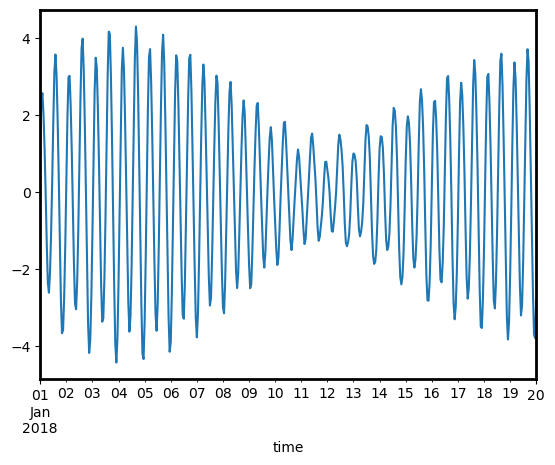

In [3]:
tide_df.reset_index(["x", "y"], drop=True).tide_height.plot();

### Multiple models

By default, `model_tides` will model tides using the FES2014 tide model. 
However, we can easily model tides using multiple models by passing a list of models to the `model` parameter.
`eo-tides` will process these in parallel where possible, and return the data into a single `pandas.DataFrame`.

For example, we can model tides using the FES2014 and HAMTIDE11 models.

<div class="alert alert-info">
    
**Note:** Here we also set `output_format="wide"`, which will place data from each model into a new column.
    This can make it easier to plot our data. For more details, [see below](#"Wide"-and-"long"-output-formats).

</div>

In [4]:
tide_df_multiple = model_tides(
    x=122.2186,
    y=-18.0008,
    model=["FES2014", "HAMTIDE11"],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", freq="1h"),
    output_format="wide",
    directory=directory,
)

# Print outputs
tide_df_multiple.head()

Modelling tides using FES2014, HAMTIDE11 in parallel


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Converting to a wide format dataframe


,,tide_model,FES2014,HAMTIDE11
time,x,y,,
2018-01-01 00:00:00,122.2186,-18.0008,1.285507,1.422702
2018-01-01 01:00:00,122.2186,-18.0008,2.360098,2.302042
2018-01-01 02:00:00,122.2186,-18.0008,2.573156,2.537032
2018-01-01 03:00:00,122.2186,-18.0008,2.035899,2.072846
2018-01-01 04:00:00,122.2186,-18.0008,1.126837,1.034931


Plot our outputs to see both models on a graph:

<Axes: xlabel='time'>

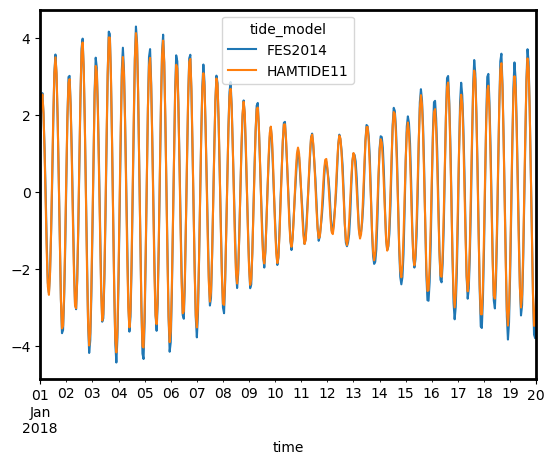

In [5]:
# Print outputs
tide_df_multiple.reset_index(["x", "y"], drop=True).plot(legend=True)

### "One-to-many" and "one-to-one" modes

By default, the `model_tides` function operates in **"one-to-many"** mode, which will model tides for every requested timestep, at every requested location.
This is particularly useful for satellite Earth observation applications where we may want to model tides for every satellite acquisition through time, across a large set of satellite pixels.

For example, if we provide two locations and two timesteps, the function will return:
```
2 locations * 2 timesteps = 4 modelled tides
```

In [6]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    mode="one-to-many",
    directory=directory,
)

Modelling tides using FES2014 in parallel


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,FES2014,1.268451
2018-01-20,122.21,-18.20,FES2014,-2.900882
2018-01-01,122.22,-18.21,FES2014,1.270160
2018-01-20,122.22,-18.21,FES2014,-2.916972


However, another common use case is having a list of locations and matching timesteps that you want to use to model tides.
Using **"one-to-one"** mode, we can model tides for each unique pair of locations and times:
```
2 timesteps at 2 locations = 2 modelled tides
```

For example, you may have a `pandas.DataFrame` containing `x`, `y` and `time` values:

In [7]:
df = pd.DataFrame(
    {
        "time": pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
        "x": [122.21, 122.22],
        "y": [-18.20, -18.21],
    }
)
df

,time,x,y
0,2018-01-01,122.21,-18.20
1,2018-01-20,122.22,-18.21


We can pass these values to `model_tides` directly, and run the function in "one-to-one" mode to return a tide height for each unique row:

In [8]:
# Model tides and add back into dataframe
df["tide_height"] = model_tides(
    x=df.x,
    y=df.y,
    time=df.time,
    mode="one-to-one",
    directory=directory,
).tide_height.values

# Print dataframe with added tide height data:
df.head()

Modelling tides using FES2014 in parallel


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


,time,x,y,tide_height
0,2018-01-01,122.21,-18.20,1.268451
1,2018-01-20,122.22,-18.21,-2.916972


### "Wide" and "long" output formats
By default, modelled tides will be returned in **"long"** format, with multiple models stacked under a `tide_models` column and tide heights in the `tide_height` column:


In [9]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    model=["FES2014", "HAMTIDE11"],
    output_format="long",
    directory=directory,
)

Modelling tides using FES2014, HAMTIDE11 in parallel


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


,,,tide_model,tide_height
time,x,y,,
2018-01-01,122.21,-18.20,FES2014,1.268451
2018-01-20,122.21,-18.20,FES2014,-2.900882
2018-01-01,122.22,-18.21,FES2014,1.270160
2018-01-20,122.22,-18.21,FES2014,-2.916972
2018-01-01,122.21,-18.20,HAMTIDE11,1.435844
2018-01-20,122.21,-18.20,HAMTIDE11,-2.662284
2018-01-01,122.22,-18.21,HAMTIDE11,1.435844
2018-01-20,122.22,-18.21,HAMTIDE11,-2.662284


We can also run the function in **"wide"** format, which will return a new column for each tide model (e.g. `FES2014`, `HAMTIDE11` etc):

In [10]:
model_tides(
    x=[122.21, 122.22],
    y=[-18.20, -18.21],
    time=pd.date_range(start="2018-01-01", end="2018-01-20", periods=2),
    model=["FES2014", "HAMTIDE11"],
    output_format="wide",
    directory=directory,
)

Modelling tides using FES2014, HAMTIDE11 in parallel


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Converting to a wide format dataframe


tide_model                 FES2014  HAMTIDE11
time       x      y                          
2018-01-01 122.21 -18.20  1.268451   1.435844
           122.22 -18.21  1.270160   1.435844
2018-01-20 122.21 -18.20 -2.900882  -2.662284
           122.22 -18.21 -2.916972  -2.662284